In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import haversine as hs
import random
import string
import xgboost as xgb
import seaborn as sns
from datetime import datetime
from hurricaneModels import HurricaneModel
from haversine import haversine, Unit
from sklearn import svm
from sklearn.linear_model import LinearRegression

## Pre-Processing

In [2]:
# Importing Data
data_folder = glob.glob('matToPyData/*.csv')
data_folder.sort()
data_list = []

for file in data_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    df.drop(df.columns[3], inplace = True, axis = 1) # dropping fake numeric date
    data_list.append(df)



matToPyData/bestStormData_1.csv
matToPyData/bestStormData_2.csv
matToPyData/bestStormData_3.csv
matToPyData/bestStormData_4.csv
matToPyData/bestStormData_5.csv
matToPyData/bestStormData_6.csv
matToPyData/bestStormData_7.csv


In [3]:
# Importing Data Dates
dates_folder = glob.glob('matToPyDates/*.csv')
dates_folder.sort()
dates_list = []

for file in dates_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    dates_list.append(df)

matToPyDates/bestStormDates_1.csv
matToPyDates/bestStormDates_2.csv
matToPyDates/bestStormDates_3.csv
matToPyDates/bestStormDates_4.csv
matToPyDates/bestStormDates_5.csv
matToPyDates/bestStormDates_6.csv
matToPyDates/bestStormDates_7.csv


### Feature Engineering

In [4]:
random.seed(10)
final_data_list = []
for i in range(0, len(dates_list)):
    df = pd.concat([data_list[i], dates_list[i]], axis = 1)
    df.columns = ['lat', 'long', 'distance', 'azimuth', 'speed', 'cp', 'windspeed', 
                  'landfall_flag', 'overland_flag', 'maxwind', 'min_cp','rad_maxwind', 'eye_diam', 'pressure_isobar', 'rad_isobar' ,'date_time']
    #print(df.shape)
    
    df = df[df['lat'].between(-90,90)] # removing impossible long lat values
    df = df[df['long'].between(-180,180)]
    
    #print(df.shape)

    df['SID'] = random.choice(string.ascii_uppercase) + '_' + str(i + 1) #assigning IDs

    df['date_time'] = pd.to_datetime(df['date_time']) # converting dates to timedate

    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day_of_week
    df['month'] = df['date_time'].dt.month
    final_data_list.append(df)

In [5]:
def haversine(lat1, lat2, lon1, lon2):
    p1 = (lat1, lon1)
    p2 = (lat2, lon2)
    return hs.haversine(p1, p2)

# Adding between point distance as a feature
for data in final_data_list:
    data.loc[0, 'derived_distance'] = 0
    for i in range(1, len(data)):
        data.loc[i, 'derived_distance'] = haversine(data.iloc[i-1, :]['lat'], 
                                                     data.iloc[i, :]['lat'], 
                                                     data.iloc[i-1, :]['long'], 
                                                     data.iloc[i, :]['long'])

In [6]:
# Exporting all final preprocessed data:
k = 1
for data in final_data_list:
    data.to_csv('/Users/jasonluo/Documents/Hurricane_proj/finalPreprocData/final_dataset' + str(k) + '.csv', 
                index = False)
    k += 1

## Analysis

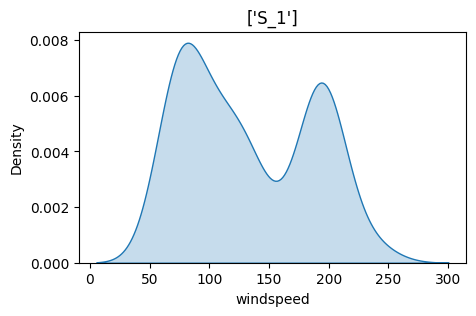

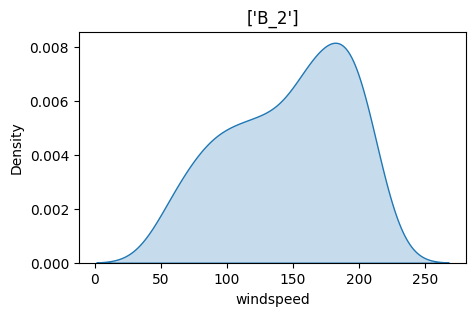

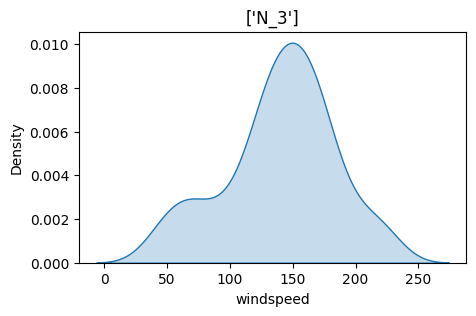

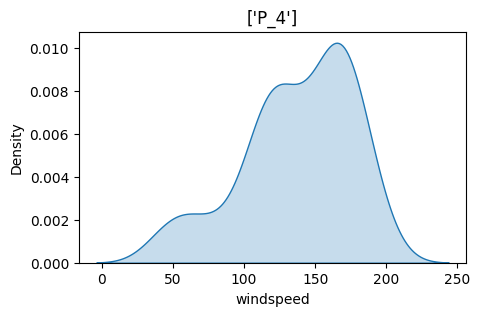

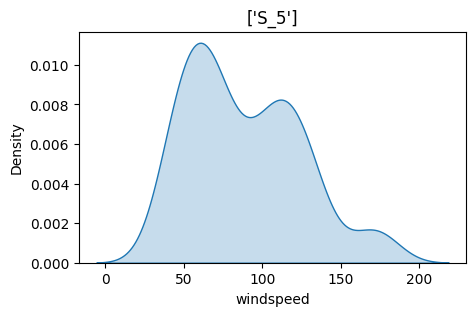

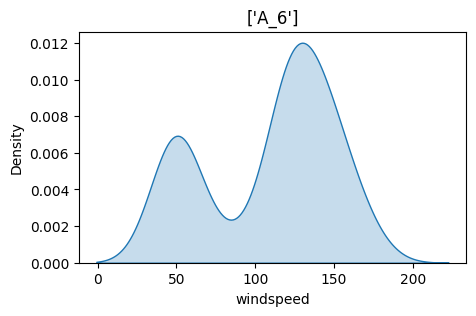

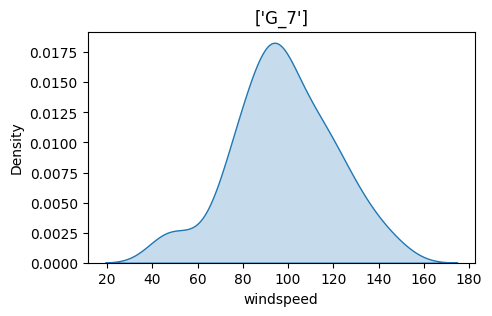

In [7]:

for i in range(0, len(final_data_list)):
    plt.figure(figsize = [5,3])
    plt.title(pd.unique(final_data_list[i]['SID']))
    sns.kdeplot(x = final_data_list[i]['windspeed'], 
                        fill = True)

In [8]:
feats = ['lat', 'long', 'speed', 'cp', 'derived_distance', 'day', 'hour', 'month']
target = 'windspeed'
ratio = 0.5

# 3 models, XGB, SVR, and Linear Regression
model1 = xgb.XGBRegressor(n_estimators = 500, 
                          learning_rate = 0.01,
                          n_jobs = 10)
model2 = svm.SVR(kernel = 'linear', 
                 epsilon=0.2)
model3 = LinearRegression()

['S_1'] MSE: 404.26048349469716 MAE: 16.166449969090856 MAPE: 17.709330951067315
['B_2'] MSE: 2051.7066101333203 MAE: 38.906318842633674 MAPE: 31.20665886263857
['N_3'] MSE: 3685.9859939592557 MAE: 41.93247888630845 MAPE: 42.11557262110224
['P_4'] MSE: 1996.9715316366492 MAE: 32.37719318772591 MAPE: 21.722577980973053
['S_5'] MSE: 216.6388114569483 MAE: 13.230264808814267 MAPE: 14.90056951710916
['A_6'] MSE: 754.6624851076757 MAE: 23.744881923467467 MAPE: 28.4956916326289
['G_7'] MSE: 355.9016859658191 MAE: 16.521949747108657 MAPE: 15.972960093452052


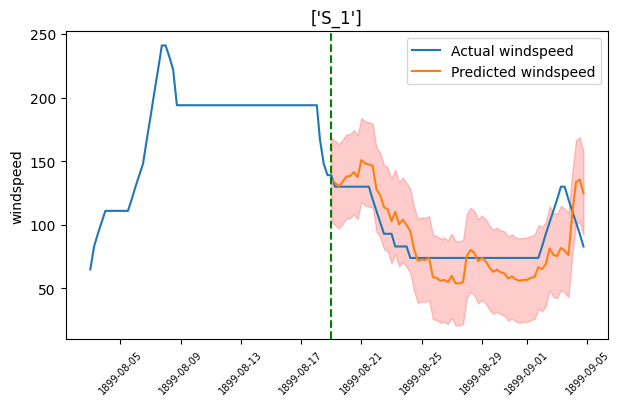

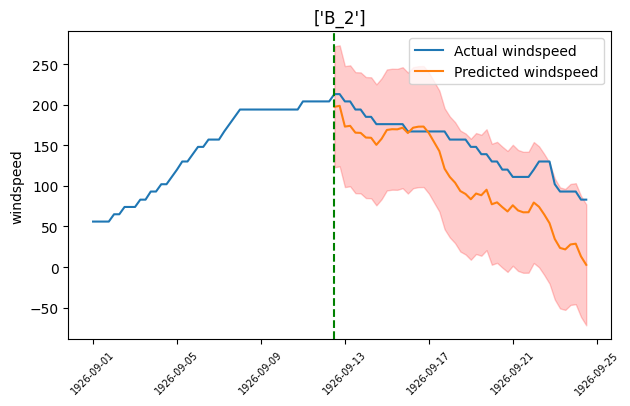

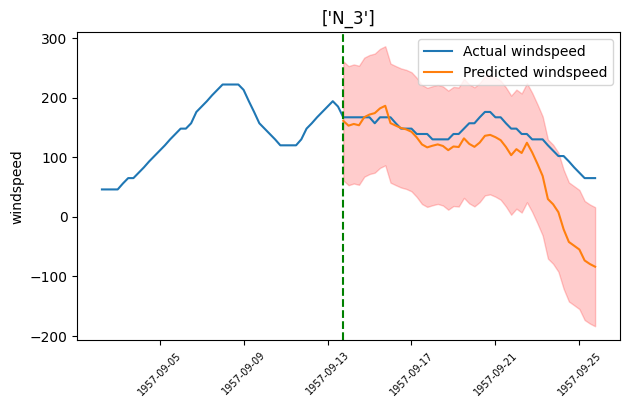

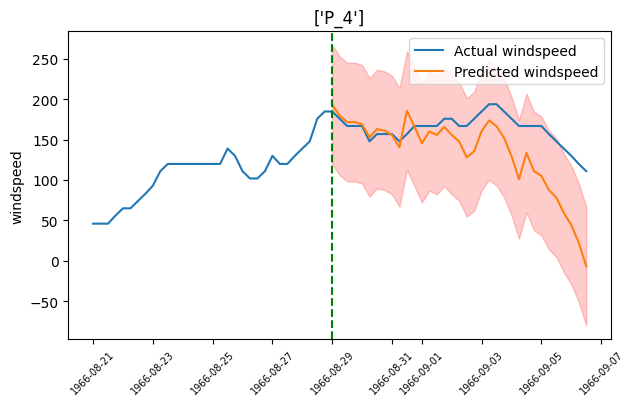

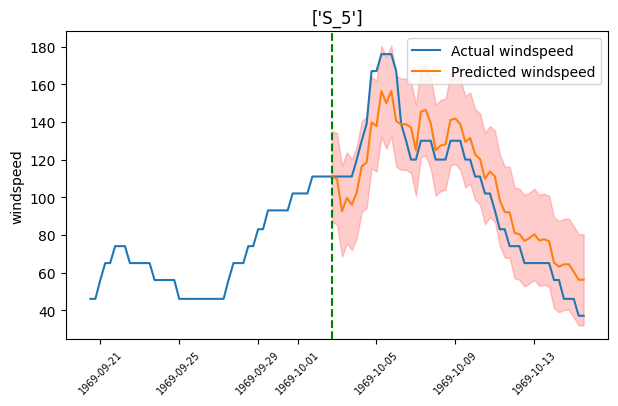

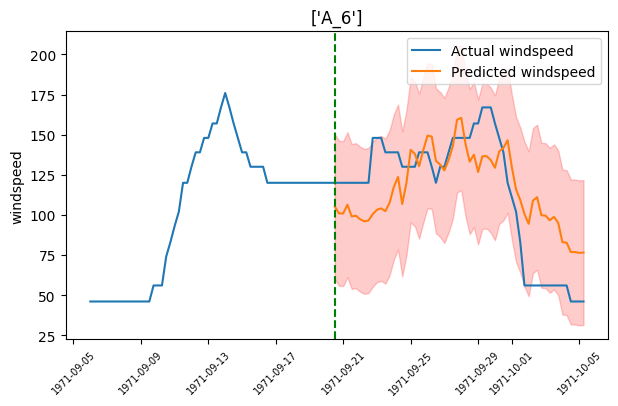

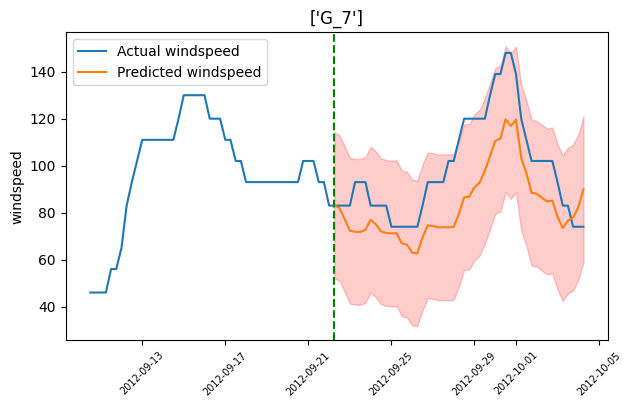

In [9]:
# Uses features at current time step
for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    Hmodel.split_train_predict(ratio, feats, target, True)
    #Hmodel.plotACF(target)

In [10]:
# With using lagged wind speed as a feature
# Lagged feature (in this case lagged windspeed) improves performance significantly

feats = ['lat', 'long', 'speed', 'cp', 'derived_distance', 'day', 'hour', 'month', 'windspeed_lag']
target = 'windspeed'
ratio = 0.5

for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    Hmodel.addLaggedTarget(target, lag = 1)
    Hmodel.split_train_predict(ratio, feats, target, True)
    #Hmodel.plotACF(target)

KeyError: "['windspeed_lag'] not in index"

['S_1'] MSE: 20.085561973274533 MAE: 3.523965221569652 MAPE: 3.866593639235199
['B_2'] MSE: 91.59093534268763 MAE: 7.820336059325214 MAPE: 5.725839481061131
['N_3'] MSE: 1869.001774141719 MAE: 35.48976254852272 MAPE: 32.38560645895966
['P_4'] MSE: 3574.1168013464635 MAE: 46.619903575003995 MAPE: 30.705484435673252
['S_5'] MSE: 72.41980495713372 MAE: 5.764257196095551 MAPE: 5.975999479362434
['A_6'] MSE: 117.15772665377871 MAE: 8.128408351329718 MAPE: 8.523155036818258
['G_7'] MSE: 48.89518521763622 MAE: 5.132850468411268 MAPE: 4.998239897370364


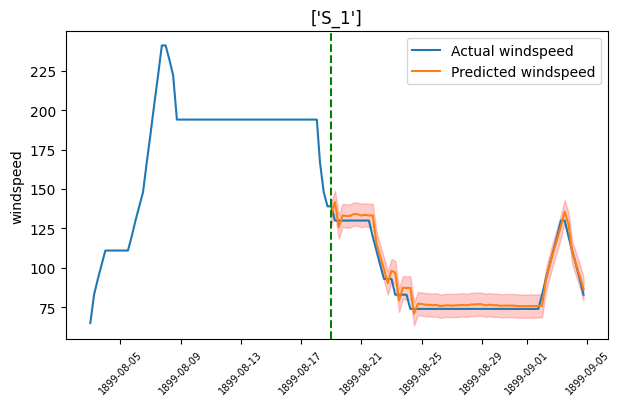

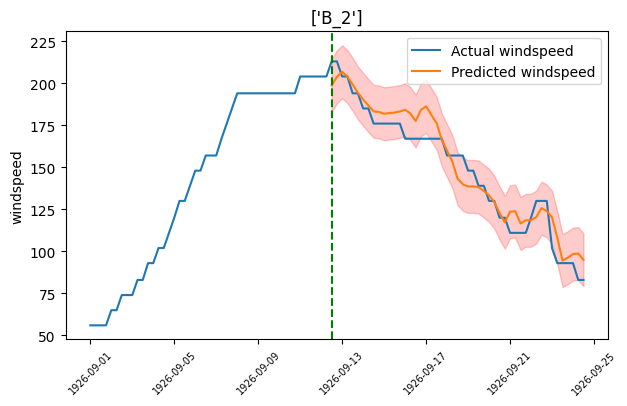

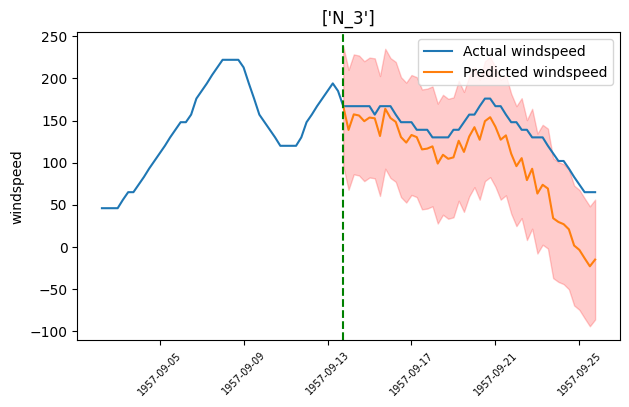

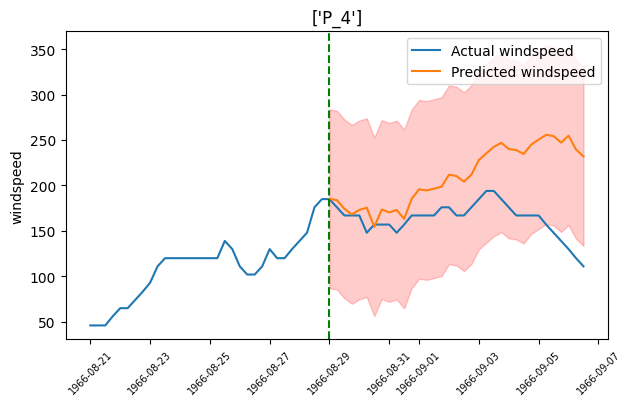

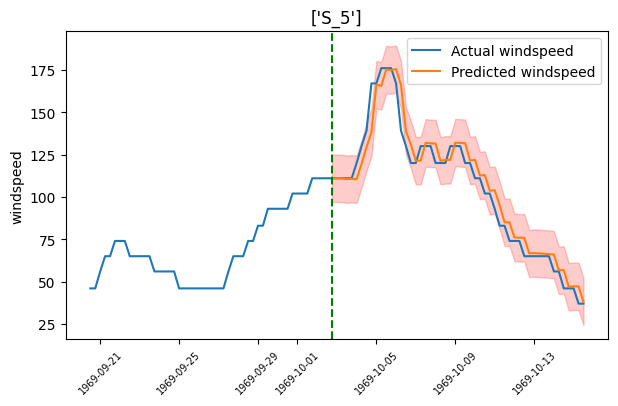

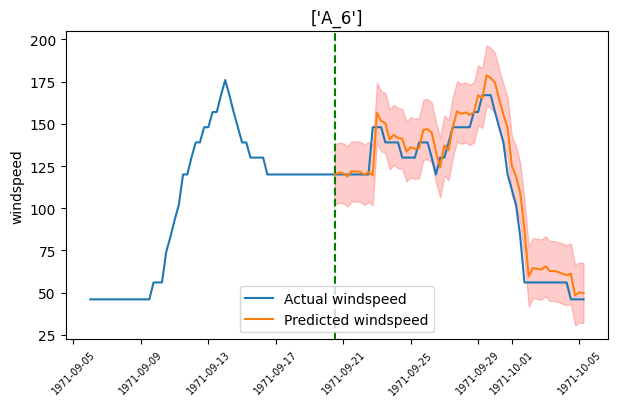

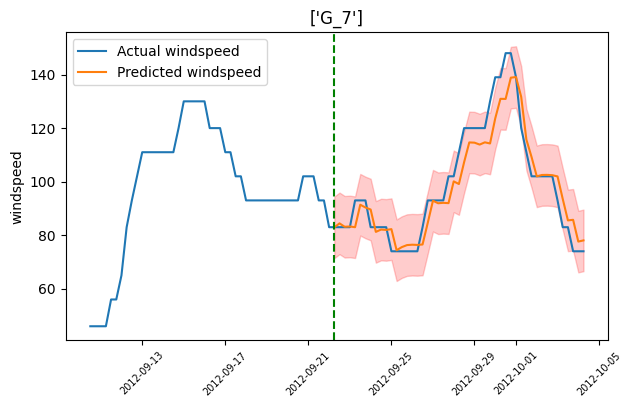

In [ ]:
# Using majority lagged features
# Lagged features include one timestep lag and two timestep lag
lagged_feats = ['lat', 'long', 'speed', 'cp', 'windspeed']
Xfeats = ['derived_distance', 'windspeed_lag1', 'lat_lag1', 'long_lag1', 'speed_lag1', 'cp_lag1',
          'windspeed_lag2', 'lat_lag2', 'long_lag2', 'speed_lag2', 'cp_lag2']
target = 'windspeed'
ratio = 0.5

for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    for feats in lagged_feats:
        Hmodel.addLaggedTarget(feats, lag = 1)
        Hmodel.addLaggedTarget(feats, lag = 2)
    Hmodel.split_train_predict(ratio, Xfeats, target, True)
    #Hmodel.plotACF(target)
    